## Sequential Data Prediction using RNN, Single Point Prediction
#### predicting using trig functions

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [2]:
t = np.arange(0, 2000, 0.1); print(len(t))

20000


In [6]:
def trig_function(t):
    temp_sin = 3 * np.power(np.sin(t),9)
    temp_cos = 2 * np.power(np.cos(t),9)
    r = np.random.rand(len(t))
    return temp_sin + temp_cos + 0.5*r

In [7]:
trig_data_original = trig_function(t)

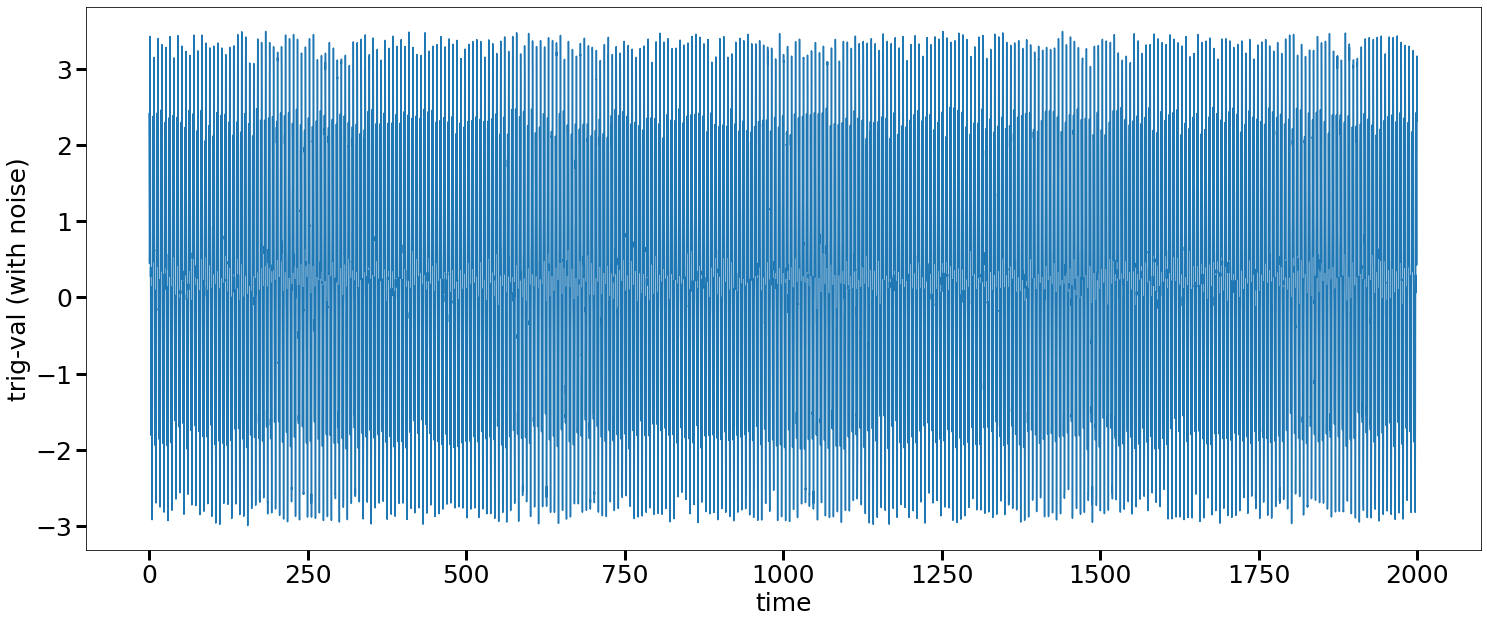

In [8]:
plt.figure(figsize=(25,10))
#plt.scatter(t, trig_data, marker='x')
plt.plot(t, trig_data_original)
plt.tick_params(axis='both', which='major', labelsize=25,length=10,width=3)
plt.xlabel(xlabel='time', size='25')
plt.ylabel(ylabel='trig-val (with noise)', size='25')
plt.show()

## Single Step Model: Predicts One data point into future

### Making appropriate training, testing data

> probably the most important part out of all this.

In [9]:
trig_data = np.copy(trig_data_original)

In [10]:
trig_series = pd.Series(data=trig_data, index=t, name="Trig Data")
train_end_index = int(len(trig_series) * 0.8); train_end_index

16000

In [11]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [12]:
# time to scale these features and standardize using training data

train_data_mean = trig_data[:train_end_index].mean()
train_data_std = trig_data[:train_end_index].std()
print(train_data_mean, train_data_std)
trig_data = (trig_data - train_data_mean)/train_data_std

0.24968077780612935 1.5600182361124673


In [13]:
# choose {trig_past_history} vals to use to predict {trig_future_target + 1} vals into the future
trig_past_history = 75
trig_future_target = 0

x_train_trig, y_train_trig = univariate_data(trig_data, 0, train_end_index, trig_past_history, trig_future_target)

x_val_trig, y_val_trig = univariate_data(trig_data, train_end_index, None, trig_past_history, trig_future_target)

In [14]:
print(x_train_trig.shape, y_train_trig.shape)
print(x_train_trig.shape[-2:])

(15925, 75, 1) (15925,)
(75, 1)


In [15]:
print(x_val_trig.shape, y_val_trig.shape)

(3925, 75, 1) (3925,)


Past history example:
 [[ 1.387813  ]
 [ 1.21180086]
 [ 1.03768928]
 [ 0.87801723]
 [ 0.7060992 ]
 [ 0.24257607]
 [ 0.14749087]
 [ 0.12603516]
 [ 0.20330002]
 [ 0.23475711]
 [ 0.41010027]
 [ 0.80832007]
 [ 1.088745  ]
 [ 1.42953224]
 [ 1.65548218]
 [ 2.03803036]
 [ 1.99632158]
 [ 1.68071352]
 [ 1.55950472]
 [ 1.10207394]
 [ 0.67211595]
 [ 0.36544429]
 [ 0.20810494]
 [ 0.01259118]
 [ 0.0951549 ]
 [-0.30945397]
 [-0.16113543]
 [-0.63561497]
 [-0.83728579]
 [-0.82590279]
 [-1.28712882]
 [-1.15168063]
 [-1.32059061]
 [-0.99933103]
 [-0.9803492 ]
 [-0.84349697]
 [-0.62421868]
 [-0.35893755]
 [-0.07344866]
 [-0.12354356]
 [-0.21021791]
 [-0.19143174]
 [-0.69892457]
 [-0.92994042]
 [-1.15704131]
 [-1.46573894]
 [-1.94956381]
 [-2.03067154]
 [-1.85467577]
 [-1.65013325]
 [-1.16992432]
 [-0.90248416]
 [-0.54083142]
 [-0.4167922 ]
 [-0.16199634]
 [-0.07399114]
 [ 0.22688588]
 [ 0.27866691]
 [ 0.50508269]
 [ 0.50837798]
 [ 0.7876912 ]
 [ 1.12832985]
 [ 1.13550071]
 [ 1.36459317]
 [ 1.10641519]
 [

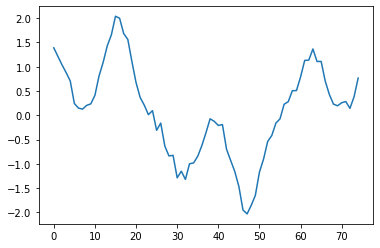

In [16]:
print("Past history example:\n", x_train_trig[0])
print("using this history to predict the val: ", y_train_trig[0])
plt.plot(x_train_trig[0])

In [17]:
# much of below code is derived from https://www.tensorflow.org/tutorials/structured_data/time_series

BATCH_SIZE = 300
BUFFER_SIZE = 10000

train_trig = tf.data.Dataset.from_tensor_slices((x_train_trig, y_train_trig))
train_trig = train_trig.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_trig = tf.data.Dataset.from_tensor_slices((x_val_trig, y_val_trig))
val_trig = val_trig.batch(BATCH_SIZE).repeat()

In [18]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_trig.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [19]:
lstm_prediction_model.compile(optimizer='adam', loss='mae')

In [20]:
lstm_prediction_model.fit(train_trig, epochs=10, steps_per_epoch=200, validation_data=val_trig, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 28s 142ms/step - loss: 0.5582 - val_loss: 0.3142
Epoch 2/10
200/200 [==============================] - 26s 129ms/step - loss: 0.2180 - val_loss: 0.1403
Epoch 3/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1129 - val_loss: 0.1067
Epoch 4/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1015 - val_loss: 0.0995
Epoch 5/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0963 - val_loss: 0.0965
Epoch 6/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0939 - val_loss: 0.0942
Epoch 7/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0924 - val_loss: 0.0927
Epoch 8/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0911 - val_loss: 0.0919
Epoch 9/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0905 - val_loss: 0.0916
Epoch 10/10
200/200 [=========

In [21]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

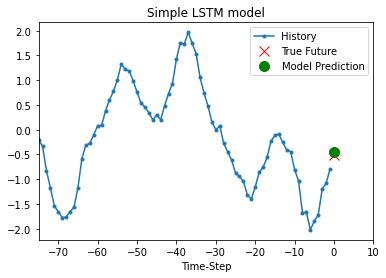

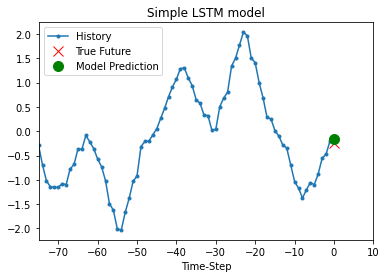

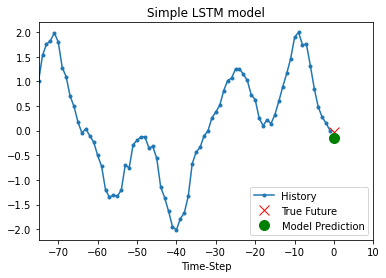

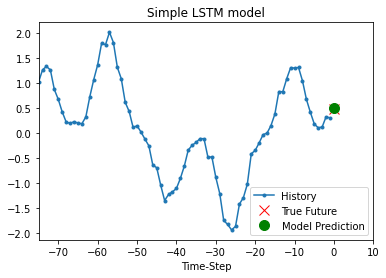

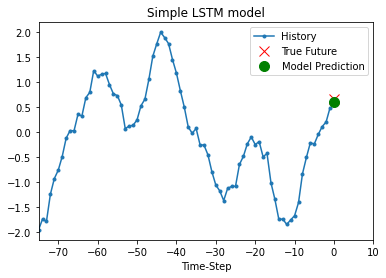

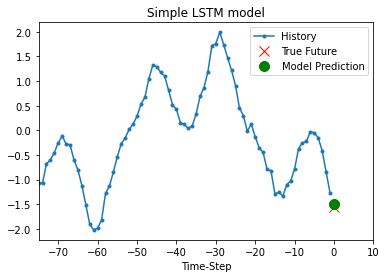

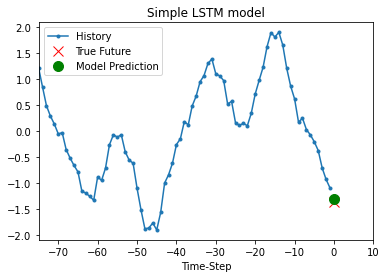

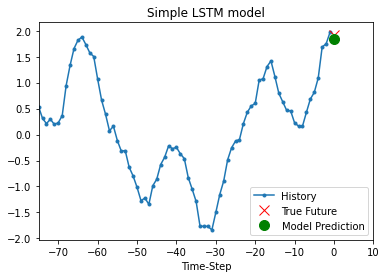

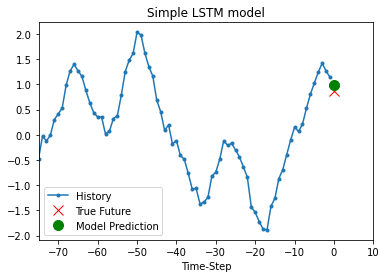

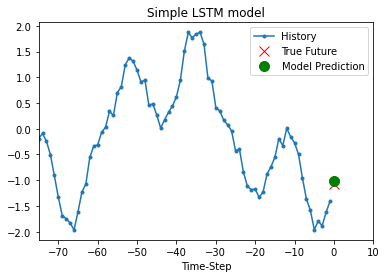

In [22]:
for x, y in val_trig.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    lstm_prediction_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()